In [22]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

def load_data_splits():
    """Loads the train, validation, and test data splits."""
    train_df = pd.read_csv('data/train.csv')
    val_df = pd.read_csv('data/validation.csv')
    test_df = pd.read_csv('data/test.csv')
    return train_df, val_df, test_df

def vectorize_data(train_texts, val_texts, test_texts):
    """Vectorizes text data using TF-IDF."""
    vectorizer = TfidfVectorizer(stop_words='english')
    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(val_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train, X_val, X_test, vectorizer

def fit_model(X_train, y_train):
    """Fits a Logistic Regression model."""
    model = LogisticRegression(max_iter=200)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X, y_true):
    """Evaluates the model and prints metrics."""
    y_pred = model.predict(X)
    precision = precision_score(y_true, y_pred, pos_label=1)
    print(f"Precision: {precision:.4f}")
    print(classification_report(y_true, y_pred))
    return precision

def benchmark_models(X_train, y_train, X_test, y_test):
    """Scores three benchmark models and selects the best one based on precision."""
    models = {
        "Logistic Regression": LogisticRegression(max_iter=200),
        "Naive Bayes": MultinomialNB(),
        "Support Vector Machine": SVC()
    }
    
    best_model = None
    best_precision = 0

    for name, model in models.items():
        model.fit(X_train, y_train)
        precision = evaluate_model(model, X_test, y_test)
        print(f"{name} Test Precision: {precision:.4f}")
        if precision > best_precision:
            best_model = model
            best_precision = precision

    print(f"Best Model: {best_model.__class__.__name__} with Precision: {best_precision:.4f}")
    return best_model

if __name__ == "__main__":
    # Load data
    train_df, val_df, test_df = load_data_splits()

    # Vectorize text data
    X_train, X_val, X_test, vectorizer = vectorize_data(
        train_df['Message'], val_df['Message'], test_df['Message']
    )
    y_train, y_val, y_test = train_df['Label'], val_df['Label'], test_df['Label']

    # Fit and evaluate the model on train and validation
    model = fit_model(X_train, y_train)
    print("Train Evaluation:")
    evaluate_model(model, X_train, y_train)
    print("Validation Evaluation:")
    evaluate_model(model, X_val, y_val)

    # Benchmark models on the test data based on precision
    best_model = benchmark_models(X_train, y_train, X_test, y_test)


Train Evaluation:
Precision: 0.9969
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2891
           1       1.00      0.73      0.84       448

    accuracy                           0.96      3339
   macro avg       0.98      0.86      0.91      3339
weighted avg       0.96      0.96      0.96      3339

Validation Evaluation:
Precision: 0.9811
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       964
           1       0.98      0.70      0.82       149

    accuracy                           0.96      1113
   macro avg       0.97      0.85      0.90      1113
weighted avg       0.96      0.96      0.95      1113

Precision: 0.9903
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       964
           1       0.99      0.68      0.81       150

    accuracy                           0.96      1114
   macro avg       0.97      0.84

## Viualization

In [ ]:
!pip install wordcloud


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


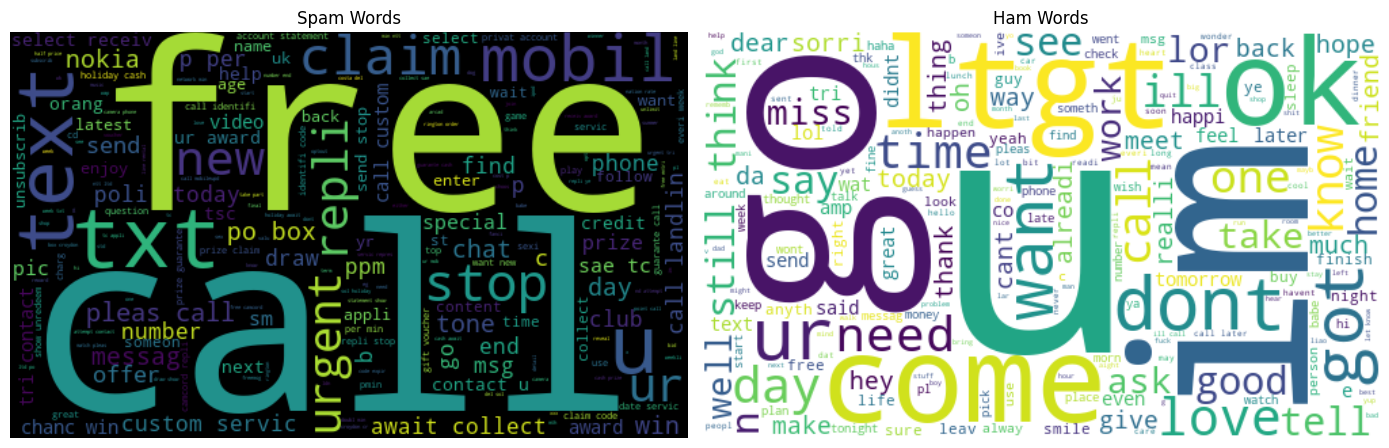

In [18]:
from wordcloud import WordCloud

def plot_word_clouds(df):
    """Generates word clouds for spam and ham messages."""
    spam_words = ' '.join(df[df['Label'] == 1]['Message'])
    ham_words = ' '.join(df[df['Label'] == 0]['Message'])

    plt.figure(figsize=(14, 7))

    # Spam Word Cloud
    plt.subplot(1, 2, 1)
    spam_cloud = WordCloud(width=500, height=300, background_color='black').generate(spam_words)
    plt.imshow(spam_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Spam Words')

    # Ham Word Cloud
    plt.subplot(1, 2, 2)
    ham_cloud = WordCloud(width=500, height=300, background_color='white').generate(ham_words)
    plt.imshow(ham_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Ham Words')

    plt.tight_layout()
    plt.show()

# Call this function
plot_word_clouds(train_df)


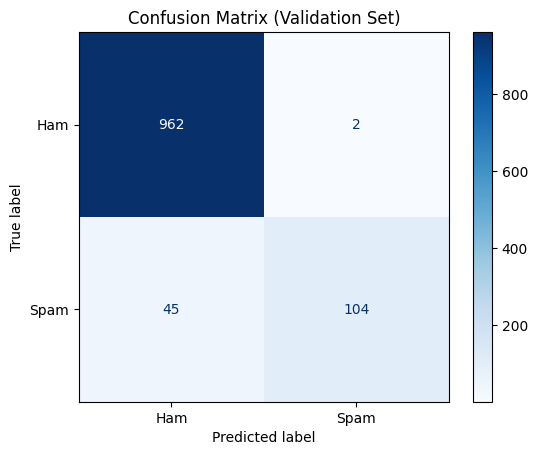

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, title):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.show()

# Plot confusion matrix after evaluating the model
y_val_pred = model.predict(X_val)
plot_confusion_matrix(y_val, y_val_pred, "Confusion Matrix (Validation Set)")


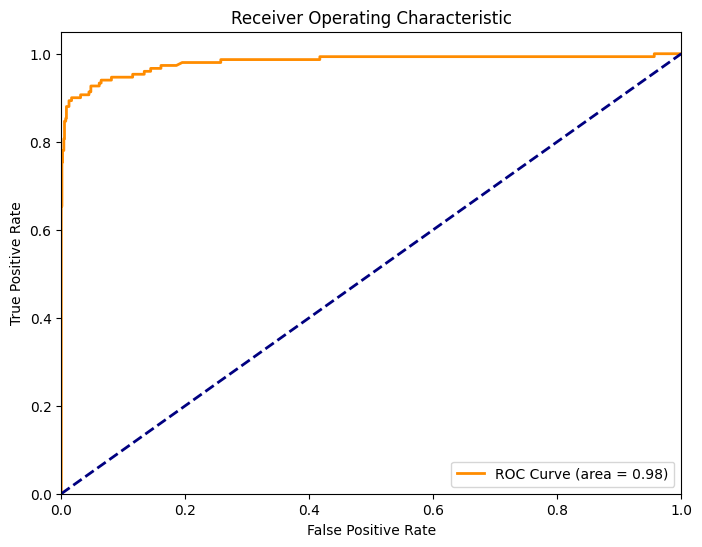

In [20]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test):
    """Plots the ROC curve for the classifier."""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curve
plot_roc_curve(model, X_test, y_test)


C:\Users\kironmoy Roy\AppData\Local\Temp\ipykernel_15912\3108024436.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(models), y=list(precisions), palette='rocket')


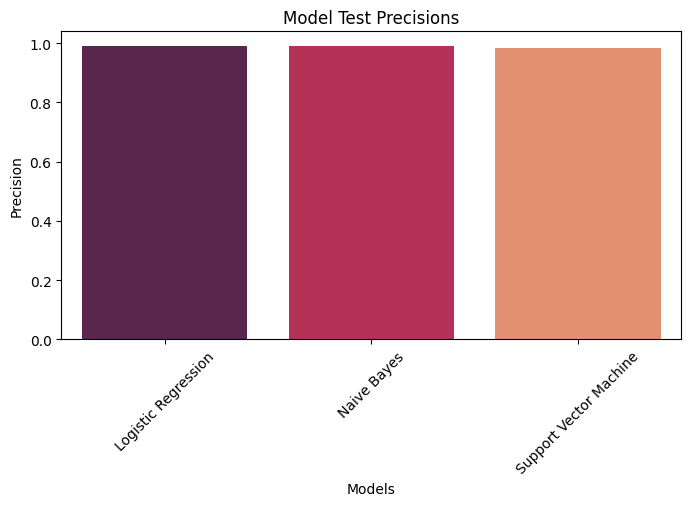

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score

def plot_model_precisions(model_precisions):
    """Plots model precisions as a bar plot."""
    models, precisions = zip(*model_precisions.items())
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(models), y=list(precisions), palette='rocket')
    plt.title('Model Test Precisions')
    plt.ylabel('Precision')
    plt.xlabel('Models')
    plt.xticks(rotation=45)
    plt.show()

# Function to calculate and collect precision scores
def calculate_precision_scores(models, X_test, y_test):
    """Calculates precision for each model."""
    model_precisions = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        precision = precision_score(y_test, y_pred, pos_label=1)
        model_precisions[name] = precision
    return model_precisions

# Benchmark and plot model precisions
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(probability=True)
}

# Fit models and evaluate precision on test data
for name, model in models.items():
    model.fit(X_train, y_train)

model_precisions = calculate_precision_scores(models, X_test, y_test)

# Plot model precisions
plot_model_precisions(model_precisions)
